## Imports and stting functions

In [41]:
# @title Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import time

In [42]:
# @title Data Loader
print("Loading Data...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
x_train = train_data.data
image_size = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(-1, image_size).float() / 255

Loading Data...


In [43]:
# @title AutoEncoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, image_size), nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [44]:
#init autoencoder
autoencoder = Autoencoder()

## oracle functions
you should use to given model, loss function and x returns either the model output, the loss, the gradient and the hessian.

In [45]:
def autoencoder_oracle(model, criterion, x, return_reconstructed_x=True, return_gradient=True, return_hessian=True, return_loss=False):
    """
    Computes f(x), gradient, and Hessian for a given input x.
    """
    # Ensure input tensor requires gradient for computation
    x = x.detach().clone()
    x.requires_grad_(True)

    outputs = []

    # Forward pass
    reconstructed_x = model(x) #model output
    loss = criterion(reconstructed_x, x)

    # Return Loss or Reconstruction based on flag
    if return_loss:
        outputs.append(loss)

    if return_reconstructed_x:
        outputs.append(reconstructed_x)

    # Compute Gradient (First derivative)
    first_order_grad = None
    if return_gradient or return_hessian:
        first_order_grad = torch.autograd.grad(loss, x, create_graph=True, retain_graph=True)[0]
        if return_gradient:
            outputs.append(first_order_grad)

    # Compute Hessian (Second derivative)
    if return_hessian:
        hessian_rows = []
        if first_order_grad is not None:
            # Iterate over each element of the gradient to find its derivative w.r.t x
            for i in range(first_order_grad.size(1)):
                grad_of_grad = torch.autograd.grad(first_order_grad[:, i].sum(), x, retain_graph=True)[0]
                hessian_rows.append(grad_of_grad)

            # Stack rows to form the Hessian matrix (Batch x Dim x Dim)
            hessian_matrix = torch.stack(hessian_rows, dim=1)
            outputs.append(hessian_matrix)
        else:
            outputs.append(None)

    # Return results
    if len(outputs) == 1:
        return outputs[0]
    return tuple(outputs)

In [46]:
print("Initializing the model (Defining the function surface)...")
criterion = nn.MSELoss()
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Initializing the model (Defining the function surface)...


## Examples for optimizers

In [47]:
def gd_step(x, grad_f_x, learning_rate=0.1):
    """
    Performs one step of Gradient Descent.
    Formula: x_new = x - lr * gradient
    """
    x_new = x - learning_rate * grad_f_x

    return x_new

In [48]:
def newton_step(x, grad_f_x, hessian_f_x, learning_rate=1.0):
    """
    Performs one step of Newton-Raphson optimization on a batch.
    Shapes:
      x: (Batch, Dim)
      grad_f_x: (Batch, Dim)
      hessian_f_x: (Batch, Dim, Dim)
    """
    # 1. Calculate Inverse Hessian
    # torch.linalg.pinv handles batch dimensions automatically (Batch, D, D)
    hessian_inv = torch.linalg.pinv(hessian_f_x)

    # 2. Prepare Gradient for Batch Matrix Multiplication
    # grad_f_x is (Batch, D). We need (Batch, D, 1) for matmul
    grad_unsqueezed = grad_f_x.unsqueeze(2)

    # 3. Compute Update Direction: H^-1 * Gradient
    # (Batch, D, D) x (Batch, D, 1) -> (Batch, D, 1)
    update_direction = torch.matmul(hessian_inv, grad_unsqueezed)

    # 4. Remove extra dimension: (Batch, D, 1) -> (Batch, D)
    update_direction = update_direction.squeeze(2)

    # 5. Apply Update
    x_new = x - learning_rate * update_direction

    return x_new

In [49]:
print("--- Starting Batch Experiments ---")

# 1. Select a BATCH of samples
BATCH_SIZE = len(x_train)
sample_batch = x_train[0:BATCH_SIZE]

print(f"Processing batch of shape: {sample_batch.shape}")

# 2. Get initial state
loss_0, grad_0 = autoencoder_oracle(
    autoencoder, criterion, sample_batch,
    return_loss=True, return_gradient=True, return_hessian=False, return_reconstructed_x=False
)
print(f"Initial Mean Loss: {loss_0.item():.6f}")

--- Starting Batch Experiments ---
Processing batch of shape: torch.Size([60000, 784])
Initial Mean Loss: 0.170193


In [50]:
def run_optimization_experiment(
    optimizer_type: str,
    initial_input: torch.Tensor,
    model: nn.Module,
    criterion: nn.Module,
    epochs: int,
    learning_rate: float
):
    """
    Runs an optimization experiment on a single input using either GD or Newton's method.
    """
    x_optimized = initial_input.clone().detach()
    all_losses = []

    print(f"\nStarting {optimizer_type.upper()} optimization for {epochs} epochs (lr={learning_rate})...")

    for epoch in range(epochs):
        # Ensure x_optimized requires gradients for the oracle call
        x_optimized.requires_grad_(True)

        # Get loss, gradient, and Hessian from the oracle
        if optimizer_type == 'newton':
            loss, grad, hessian = autoencoder_oracle(
                model, criterion, x_optimized,
                return_loss=True, return_gradient=True, return_hessian=True, return_reconstructed_x=False # Explicitly set to False
            )
        else: # For GD, we only need gradient and loss
            loss, grad = autoencoder_oracle(
                model, criterion, x_optimized,
                return_loss=True, return_gradient=True, return_hessian=False, return_reconstructed_x=False # Explicitly set to False
            )
            hessian = None # Ensure hessian is None for GD

        all_losses.append(loss.item())

        # Perform the optimization step
        if optimizer_type == 'gd':
            x_optimized = gd_step(x_optimized.detach(), grad, learning_rate=learning_rate)
        elif optimizer_type == 'newton':
            if hessian is None:
                raise ValueError("Hessian is required for Newton's method but was not returned by oracle.")
            # Detach x_optimized before updating it, as newton_step re-assigns
            x_optimized = newton_step(x_optimized.detach(), grad, hessian, learning_rate=learning_rate)
        else:
            raise ValueError("Invalid optimizer type. Choose 'gd' or 'newton'.")

        # Clamp values to keep them within image range [0, 1]
        x_optimized = torch.clamp(x_optimized, 0, 1)

        # print progress
        if (epoch + 1) % (epochs // 5) == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"  Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.6f}")

    print(f"Finished {optimizer_type.upper()} optimization. Final Loss: {all_losses[-1]:.6f}")
    return x_optimized, all_losses

# Define experiment parameters
epochs = 20
gd_lr = 0.5

# Run GD experiment
x_opt_gd_loop, losses_gd = run_optimization_experiment(
    'gd', sample_batch, autoencoder, criterion, epochs, gd_lr
)


Starting GD optimization for 20 epochs (lr=0.5)...
  Epoch [1/20] Loss: 0.170193
  Epoch [4/20] Loss: 0.170193
  Epoch [8/20] Loss: 0.170193
  Epoch [12/20] Loss: 0.170193
  Epoch [16/20] Loss: 0.170192
  Epoch [20/20] Loss: 0.170192
Finished GD optimization. Final Loss: 0.170192


### Loss Curves Over Epochs

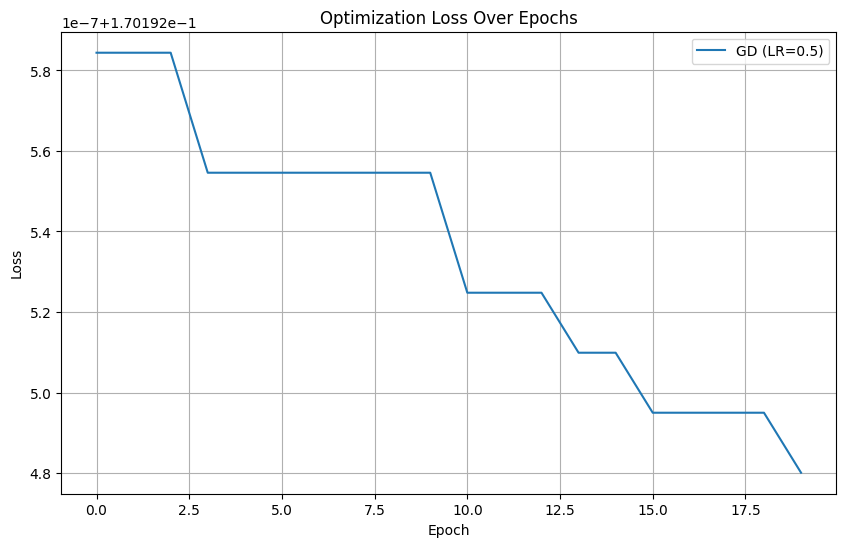

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(losses_gd, label=f'GD (LR={gd_lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimization Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Visual Comparison of Optimized Images


Visualizing Results...


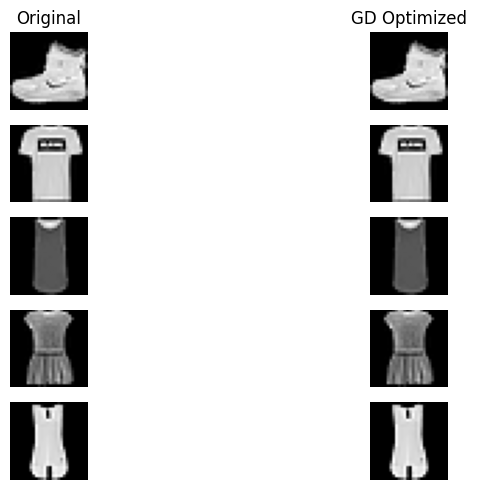

In [53]:
print("\nVisualizing Results...")

def show_batch_comparison(orig, gd, count):
    plt.figure(figsize=(12,  count))

    for i in range(count):
        # Convert tensors to numpy images
        img_orig = orig[i].detach().cpu().numpy().reshape(28, 28)
        img_gd = gd[i].detach().cpu().numpy().reshape(28, 28)

        # Original
        plt.subplot(count, 3, i*3 + 1)
        plt.imshow(img_orig, cmap='gray')
        if i == 0: plt.title("Original")
        plt.axis('off')

        # GD
        plt.subplot(count, 3, i*3 + 2)
        plt.imshow(img_gd, cmap='gray')
        if i == 0: plt.title("GD Optimized")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_batch_comparison(sample_batch, x_opt_gd, count=5)